# Лабораторная Работа "Нелинейная краевая задача"

## Задача

Решаем нелинейную краевую задачу *(XI.9.3а)*

$$\begin{cases}
y'' = x \sqrt{y}, ~0 \lt x \le 1 \\
y(0) = 0, ~y(1)=2 \\
\end{cases}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Adding ODE lab to PYTHONPATH
def update_path():
    import sys
    import os
    import pathlib

    pwd = os.getcwd()
    parent = os.path.join(*os.path.split(pwd)[:-1])
    path = os.path.join(parent, "5-6-ODE")
    sys.path.append(path)
update_path()

from solvers import RungeKuttaCollection, CALC_TYPE

Представим задачу как
$$\begin{cases}
y'' = f(x, y, y') = x \sqrt{y} \\

\frac{\partial f} {\partial y} = \frac{x}{2 \sqrt{y}} \\
\frac{\partial f} {\partial y'} = 0

\end{cases}$$

Тестировать методы будем на простой задаче:
$$\begin{cases}
y'' = -y\\
y(0) = 0, ~y(9\pi/2) = 1
\end{cases}$$

На интегральной кривой мы должны увидеть функцию $y = sin(x)$.

In [2]:
class Function:
    # f, df/dy, df/dy'
    def __init__(self, f, fdy, fdyd):
        self.f = f
        self.dy = fdy
        self.dyd = fdyd

class BoundProblem:
    def __init__(self, x1, y1, x2, y2):
        self.x1, self.x2 = x1, x2
        self.y1, self.y2 = y1, y2

# here y(0) = \epsilon << 1
# a hack to resolve uncertainty
# in df/dy(0, 0)
bp_task = BoundProblem(0, 1e-5, 1, 2)
f_task = Function(lambda x, y, yd: x*np.sqrt(y), lambda x, y, yd: x / (2 * np.sqrt(y)), lambda x, y, yd: np.zeros_like(x))

f_test = Function(lambda x, y, yd: -y, lambda x, y, yd: np.full_like(x, -1), lambda x, y, yd: np.zeros_like(x))
bp_test = BoundProblem(0, 0, 9*np.pi/2, 1)

In [3]:
def calc_err(func, X, Y, h):
    D1 = [Y[i + 1] - 2*Y[i] + Y[i-1] for i in range(1, len(Y) - 1)]
    D1 = np.array(D1, dtype=CALC_TYPE) / h**2

    Xd = X[1:-1].copy()
    Yd = Y[1:-1].copy()
    D2 = func.f(Xd, Yd, Yd)

    return Xd, np.abs(D1 - D2)

def plot_task(func, bp, solver, h, exp, title, expected = None):
    fig, (yplot, eplot) = plt.subplots(1, 2)
    X, Ys = solver(func, bp, h)
    Xd, E = calc_err(func, X, Ys[-1], h)

    yplot.plot(X, Ys[-1], label="solution")

    def calc_alpha(Ys, i):
        a = (np.exp(exp*(i)/len(Ys)) - 1) + .2
        if a > 1: a = 0
        return a

    for i, Y in enumerate(Ys[:-1]):
        yplot.plot(X, Y, "k--", alpha=calc_alpha(Ys, i), lw=1)

    print(len(Ys))

    yplot.scatter((bp.x1, bp.x2), (bp.y1, bp.y2), c="k", zorder=8)
    if expected is not None:
        yplot.plot(X, expected(X))

    eplot.plot(Xd, E)
    
    yplot.grid()
    eplot.grid()

    yplot.set_xlabel("$x$")
    yplot.set_ylabel("$y$")
    yplot.legend()

    eplot.set_xlabel("$x$")
    eplot.set_ylabel("$err$")

    yplot.set_title("Решение")
    eplot.set_title("Ошибка $err=|y''_n - f_n|$")

    fig.set_size_inches((14, 7))
    
    plt.suptitle(f"{title}\nШтрихованные линии - итерации алгоритма")
    plt.show()

## 1. Метод стрельбы

Будем реализовывать метод стрельбы через уравнение в вариациях. Исследуем задачу

$$\begin{cases}
y'' = f(x, y, y') \\
y(x_1) = y_1 \\
y(x_2) = y_2
\end{cases}$$

Находим $y(x, \alpha)$ и $u(x, \alpha) = \frac{\partial y}{\partial \alpha} (x, \alpha)$ как решения двух задач Коши:

$$\begin{cases}
y'' = f(x, y, y') \\
y(x_1) = y_1 \\
y'(x_1) = \alpha
\end{cases}$$

$$\begin{cases}
u'' = \frac{\partial f}{\partial y'}u' + \frac{\partial f}{\partial y}u\\
u(x_1) = 0 \\
u'(x_1) = 1
\end{cases}$$

Введем невязку $F(\alpha) = y(x_2, \alpha) - y_2$. Для решения краевой задачи нам необходимо решить задачу $F(\alpha) = 0$. Будем использовать метод Ньютона, причем $\frac{\partial F}{\partial \alpha}$ будет вычисляться не с помошью разностной формулы, а при помощи тождества

$$\frac{\partial F}{\partial \alpha} = \frac{\partial y}{\partial \alpha} = u(x, \alpha)$$

Итого, будем приближать $\alpha$ по схеме:

$$\alpha_{k + 1} = \alpha_{k} - \frac{F(\alpha_k)}{F'_\alpha(\alpha_k)} = \alpha_{k} - \frac{y(1, \alpha) - y_2}{u(1, \alpha)}$$

In [4]:
def shooting_method(f, bp, h, eps, alpha0 = 0):
    MAX_ITERATIONS = 1e3
    
    alpha = alpha0

    ode_solver = RungeKuttaCollection.create_e4(h)

    Xs = []
    Ys = []

    def ODE(q, x):
        y, u, yd, ud = q
        f0 = yd
        f1 = ud
        f2 = f.f(x, y, yd)
        f3 = f.dyd(x, y, yd)*ud + f.dy(x, y, yd) * u
        return np.array([f0, f1, f2, f3], dtype=CALC_TYPE)

    i = 0
    while 1:
        if i >= MAX_ITERATIONS:
            raise RuntimeError("Too much iterations")
        
        ode_solver.init_problem(ODE, bp.x1, np.array([bp.y1, 0, alpha, 1], dtype=CALC_TYPE))

        x = bp.x1
        y = None
        u = None
        Xs.append([]); Ys.append([])

        while x < bp.x2: 
            x, (y, u, _, __) = ode_solver.step()
            Xs[-1].append(x)
            Ys[-1].append(y)

        Xs[-1] = np.array(Xs[-1], dtype=CALC_TYPE)
        Ys[-1] = np.array(Ys[-1], dtype=CALC_TYPE)

        if np.abs(y - bp.y2) < eps:
            break

        alpha -= (y - bp.y2) / u
        i += 1
    
    return  Xs[0], Ys

### Валидация

2


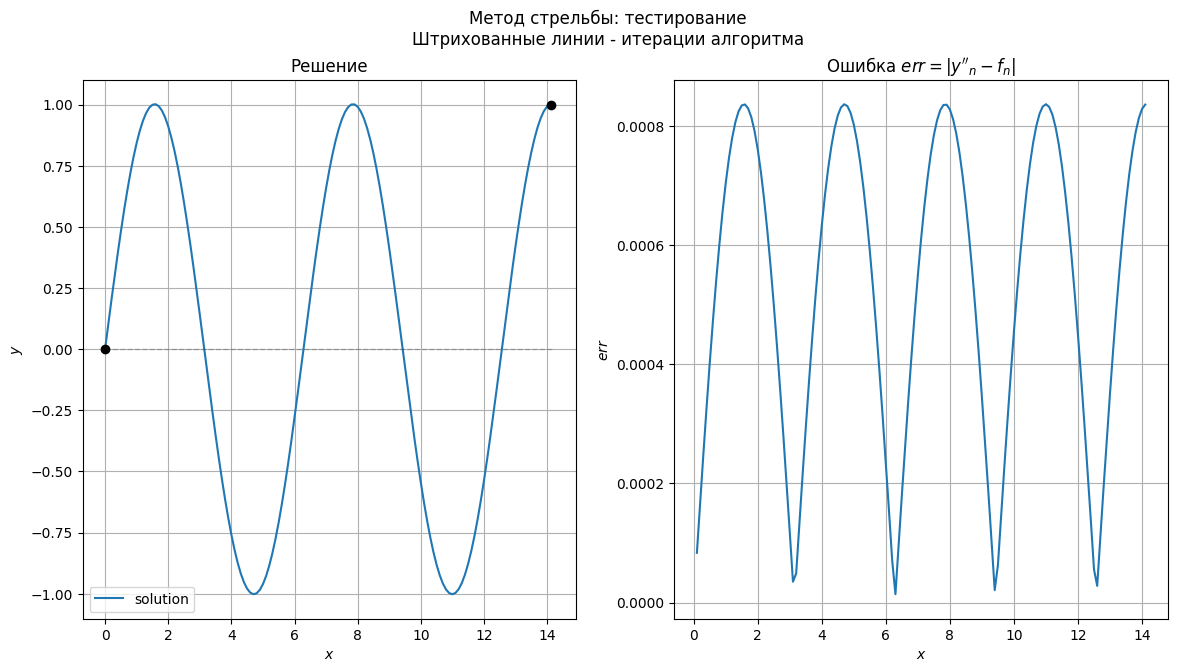

In [5]:
solver = lambda *args: shooting_method(*args, 1e-1)
plot_task(f_test, bp_test, solver, 1e-1, 1, "Метод стрельбы: тестирование")

### Решение

4


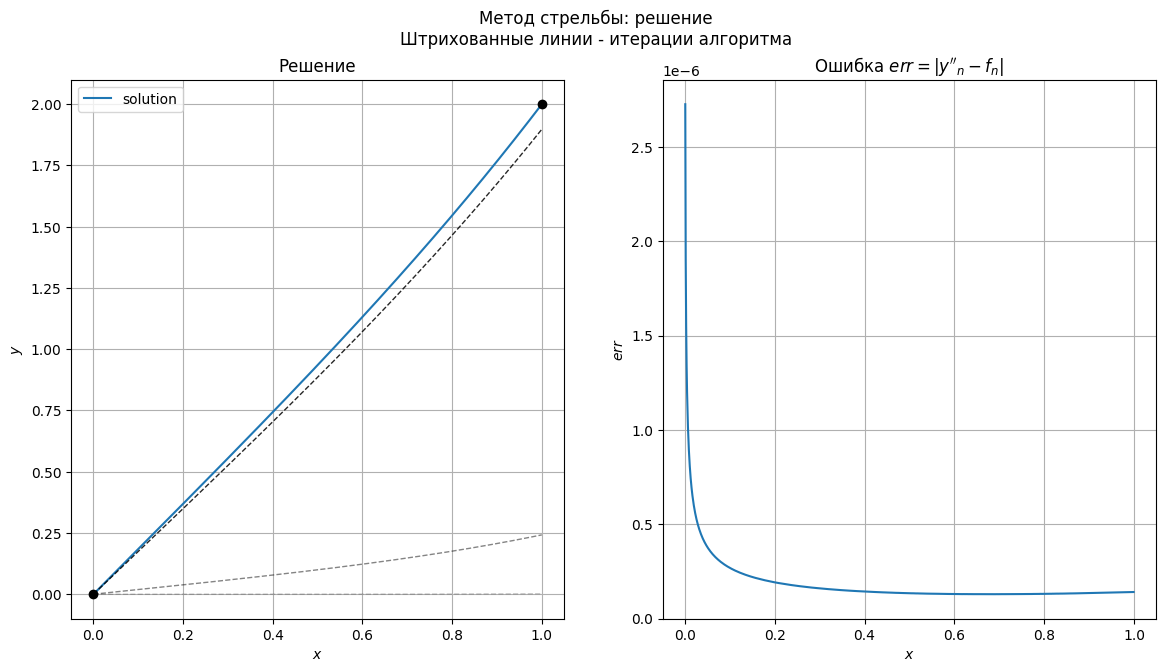

In [6]:
solver = lambda *args: shooting_method(*args, 1e-3)
plot_task(f_task, bp_task, solver, 1e-3, 1, "Метод стрельбы: решение")

## 2. Метод квазилинеаризации Ньютона

Решаем нелинейную краевую задачу

$$\begin{cases}
y'' = f(x, y, y') \\
y(x_1) = y_1 \\
y(x_2) = y_2 \\
\end{cases}$$

Для начала, необходимо подобрать нулевое приближение решения. Для этого построим прямую, удовлетворяющую граничным условиям:

$$\begin{cases}
y_0(x) = a x + b \\
y_0(x_1) = y_1 \\
y_0(x_2) = y_2 \\
\end{cases}
$$

После этого, будем итеративно приближать наше решение по следующему алгоритму:

$$\begin{cases}
y_{i + 1}(x) = y_i(x) + \nu_{i}(x) \\ 
y_{i}(x_1) = y_1,~ y_{i}(x_2) = y_2 ~ по ~индукции, \\
\nu_{i}(x_1) = \nu_{i}(x_2) = 0
\end{cases}
$$

Подставляя в исходную задачу, получим линейную краевую задачу:

$$\begin{cases}
\nu_i'' = p(x) \nu_i' + g(x) \nu + r(x),~ где \\
\nu_i(x_1) = \nu_i(x_2) = 0, \\
p(x) = \frac{\partial f}{\partial y'} (x, y_i(x), y_i'(x)), \\
g(x) = \frac{\partial f}{\partial y} (x, y_i(x), y_i'(x)), \\
r(x) = f(x, y_i(x), y_i'(x)) - y_i''
\end{cases}$$

Приблизим линейную КЗ:
$$\begin{cases}
\frac{y_{i + 1} - 2y_i + y_{i - 1}}{h^2} = p_i \frac{y_{i+1} - y_{i_1}}{2h} + g_i y_i + r_i \\
f_i := f(ih) \\
y_0 = A, ~y_{N-1} = B ~(краевые~ условия) \\
i \in [1, N-1] \\
\end{cases}$$

Получим СЛАУ с трехдиагональной матрицей относительно $Y = [y_1 ~...~ y_{N-2}]^T$:
$$\begin{cases}
y_1 \beta_1 + y_2 \gamma_1 = \delta_1 - \alpha_1 A \\
y_{i-1} \alpha_i + y_i \beta_i + \gamma_i y_{i + 1} = \delta_i, ~ i \in (2, N-2)\\
y_{N-3} \alpha_{N -2 } + y_{N -2} \beta_{N - 2} = \delta_{N-2} - \gamma_{N-2} B \\\\

\alpha_i = 1 + hp_i/2,\\
\beta_i = - 2 - h^2g_i,\\
\gamma_i = 1 - hp_i/2,\\
\delta_i = h^2r_i
\end{cases}$$

Решая эту задачу методом прогонки, получаем следующее ($y_{i+1}$) приближение. Повторяем процедуру до тех пор, пока невязка $r(x) = max|f(x, y_i(x), y_i'(x)) - y_i''(x)|$ не станет меньше желаемого $\varepsilon$.


In [7]:
def solve_tridiag(alpha, beta, gamma, delta):
    a = np.empty_like(alpha)
    b = np.empty_like(alpha)
    y = np.empty_like(alpha)

    a[1] = -gamma[0] / beta[0]
    b[1] = delta[0] / beta[0]

    for i in range(1, len(alpha) - 1):
        den = alpha[i] * a[i] + beta[i]
        a[i + 1] = - gamma[i] / den
        b[i + 1] = (delta[i] - alpha[i]*b[i]) / den

    y[-1] = (delta[-1] - alpha[-1]*b[-1]) / (alpha[-1] * a[-1] + beta[-1])

    for i in range(len(y) - 2, -1, -1):
        y[i] = a[i+1]*y[i+1] + b[i+1]
    
    return y

class ValueTable:
    def __init__(self, y, yd1, yd2):
        self.y = y
        self.yd1 = yd1
        self.yd2 = yd2

    @staticmethod
    def eval_yd1(y, h):
        return (y[2:] - y[:-2]) / (2*h)
    
    @staticmethod
    def eval_yd2(y, h):
        return (y[2:] + y[:-2] - 2*y[1:-1]) / (h**2)
    
    def reevaluate_derivatives(self, h):
        self.yd1[1:-1] = self.eval_yd1(self.y, h)
        self.yd2[1:-1] = self.eval_yd2(self.y, h)

class RFuncValueTable:
    def __init__(self, func: Function, X, val: ValueTable):
        args = X, val.y, val.yd1
        self.f = func.f(*args)
        self.dfdy = func.dy(*args)
        self.dfdyd = func.dyd(*args)

def make_linear_approximation(X, y1, y2):
    x1 = X[0]
    x2 = X[-1]

    a = (y2 - y1) / (x2 - x1)
    b = y1 - a*x1

    y = a*X + b
    yd1 = np.full_like(y, a)
    yd2 = np.zeros_like(y)

    return ValueTable(y, yd1, yd2)

def newton_method(func: Function, bp: BoundProblem, h, eps):
    x1, y1 = bp.x1, bp.y1
    x2, y2 = bp.x2, bp.y2

    X = np.arange(x1, x2+h, h, dtype=CALC_TYPE)

    y_prev = make_linear_approximation(X, y1, y2)
    f_prev = RFuncValueTable(func, X, y_prev)

    def geterr():
        return np.max(np.abs(f_prev.f - y_prev.yd2)[1:-1])

    Ys = [y_prev.y.copy()]

    while geterr() > eps:
        p = f_prev.dfdyd[1:-1]
        g = f_prev.dfdy[1:-1]
        r = (f_prev.f - y_prev.yd2)[1:-1]

        al = 1 + h*p/2
        be = -2 - h**2 * g
        ga = 1 - h*p/2
        de = r * (h**2)

        y_prev.y[1:-1] += solve_tridiag(al, be, ga, de)
        y_prev.reevaluate_derivatives(h)
        f_prev = RFuncValueTable(func, X, y_prev)

        print(geterr(), end="\r")
        Ys.append(y_prev.y.copy())
    print("\n")
    return X, Ys

### Валидация

1.2769299506665277e-14

2


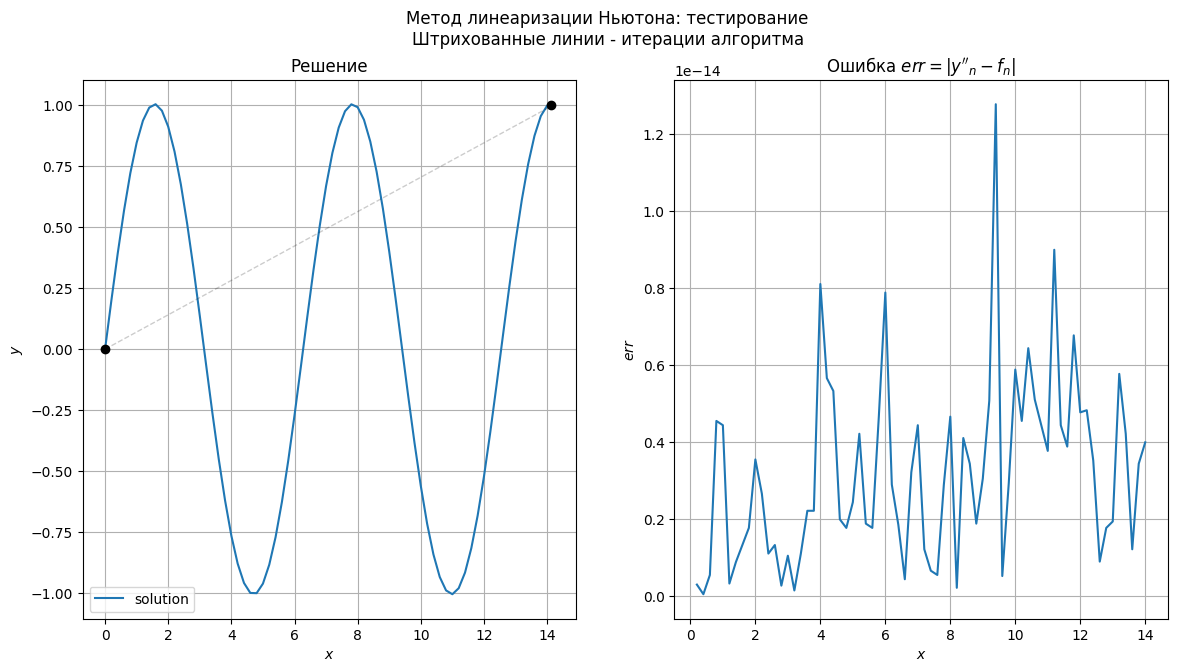

In [8]:
solver = lambda *args: newton_method(*args, 1e-2)
plot_task(f_test, bp_test, solver, .2, 1, "Метод линеаризации Ньютона: тестирование")

### Решение

4.586614421597801e-115

3


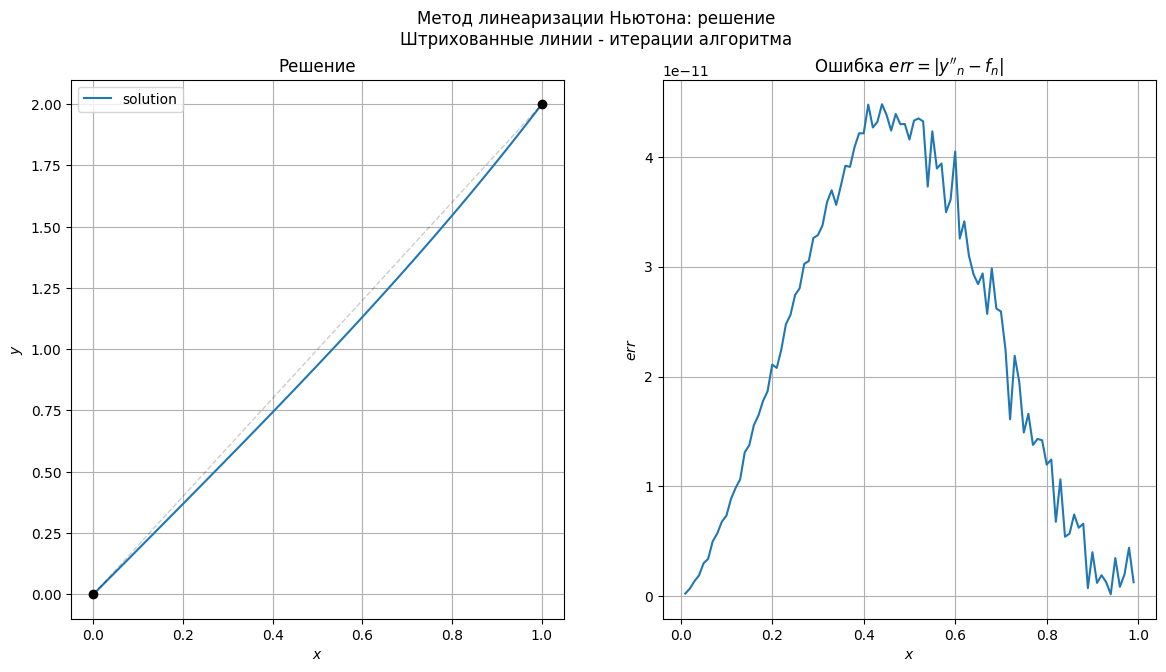

In [11]:
solver = lambda *args: newton_method(*args, 1e-4)
plot_task(f_task, bp_task, solver, 1e-2, 11, "Метод линеаризации Ньютона: решение")